<a href="https://colab.research.google.com/github/sethschober/Module-4/blob/main/notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports & declarations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import *
import tensorflow as tf

LOCAL_PATH_MINI = '../data/raw/kaggle_mini_subsample'
LOCAL_PATH_TRAIN = '../data/raw/train'
COLAB_PATH_TRAIN = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/train'
COLAB_PATH_MINI = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/mini_subsample'

RANDOM_STATE = 2020

# Comment when running locally, uncomment for Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define basic functions

In [2]:
def make_flat(x):
    s = x.shape
    dim_0 = s[0]
    dim_1 = s[1]*s[2]*s[3]
    x_flat = x.reshape(dim_0, dim_1)
    shape = (x_flat.shape[1],)
    return x_flat, shape

In [3]:
def plot_results(history, metrics=['accuracy'], val=True):
    
    for metric in metrics:
        x = range(len(history[metric]))

        plt.figure()
        plt.plot(x, history[metric], label='Train')

        if val == True:
            plt.plot(x, history['val_'+metric], label='Validation')
        plt.title(metric)
        plt.legend();

## Mini Dataset

#### Import & Clean

In [4]:
# TESTING TO GET LABEL ENCODING CORRECT

path = COLAB_PATH_MINI
data_tf = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                image_size=(32, 32),
                                                class_names=['NORMAL', 'PNEUMONIA'],
                                                seed=RANDOM_STATE)

print('CLASS NAMES:', data_tf.class_names, 'CORRESPOND TO [0,1]')
for i, item in enumerate(data_tf.as_numpy_iterator()):
    if i == 0:
        images = np.array(item[0])
        labels = np.array(item[1])
    else:
        images = np.concatenate([images, item[0]], axis=0)
        labels = np.concatenate([labels, item[1]], axis=0)
        if i % 10 == 0:
            print(int(i/(5232/BATCH_SIZE)*100), '%')

images /= 256

labels_inverted = np.array([0 if i == 1 else 1 for i in labels])
labels = np.concatenate([labels_inverted.reshape(-1,1), labels.reshape(-1,1)], axis=1)


# print('Data shape:', images.shape)
# print('Label shape:', labels.shape)

Found 200 files belonging to 2 classes.
CLASS NAMES: ['NORMAL', 'PNEUMONIA'] CORRESPOND TO [0,1]


Found 200 images belonging to 2 classes.


'Example image:'

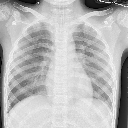

Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Dataset shape: (200, 128, 128, 3)


In [5]:
BATCH_SIZE = 250
TARGET_SIZE = [128, 128]

path = COLAB_PATH_MINI
image_generator = ImageDataGenerator().flow_from_directory(path, batch_size=BATCH_SIZE, target_size=TARGET_SIZE);
images, labels = next(image_generator)
images_scaled = images / 255

display('Example image:', array_to_img(images[0]))
print('Indices:', image_generator.class_indices)
print('Dataset shape:', images_scaled.shape)

#### Mini Dataset Model

Epoch 1/50
7/7 [==============================] - 16s 7ms/step - loss: 1.9749 - accuracy: 0.5402
Epoch 2/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6531 - accuracy: 0.6047
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6334 - accuracy: 0.6544
Epoch 4/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6270 - accuracy: 0.6638
Epoch 5/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6558 - accuracy: 0.6179
Epoch 6/50
7/7 [==============================] - 0s 7ms/step - loss: 0.6598 - accuracy: 0.6539
Epoch 7/50
7/7 [==============================] - 0s 6ms/step - loss: 0.5638 - accuracy: 0.6855
Epoch 8/50
7/7 [==============================] - 0s 6ms/step - loss: 0.5482 - accuracy: 0.7127
Epoch 9/50
7/7 [==============================] - 0s 7ms/step - loss: 0.5683 - accuracy: 0.6576
Epoch 10/50
7/7 [==============================] - 0s 7ms/step - loss: 0.8190 - accuracy: 0.5558
Epoch 11/50
7/7 [=====================

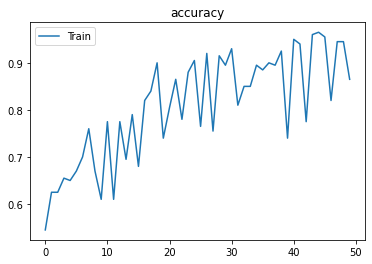

In [6]:
x, shape = make_flat(images_scaled)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=x, y=labels, epochs=50)

plot_results(history.history, val=False)

model.summary()

## Full Dataset

### Import and clean

In [4]:
path = COLAB_PATH_TRAIN
BATCH_SIZE = 32
data_tf = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                image_size=(64, 64), # Can work up to 256
                                                batch_size=BATCH_SIZE,
                                                class_names=['NORMAL', 'PNEUMONIA'],                                                
                                                seed=RANDOM_STATE)

print('CLASS NAMES:', data_tf.class_names, 'CORRESPOND TO [0,1]')

for i, item in enumerate(data_tf.as_numpy_iterator()):
    if i == 0:
        images = np.array(item[0])
        labels = np.array(item[1])
    else:
        images = np.concatenate([images, item[0]], axis=0)
        labels = np.concatenate([labels, item[1]], axis=0)
        if i % 10 == 0:
            print(int(i/(5232/BATCH_SIZE)*100), '%')

images /= 256

labels_inverted = np.array([0 if i == 1 else 1 for i in labels])
labels = np.concatenate([labels_inverted.reshape(-1,1), labels.reshape(-1,1)], axis=1)

data_tf = None # clear RAM
labels_inverted = None # clear RAM
print('Data shape:', images.shape)
print('Label shape:', labels.shape)

Found 5232 files belonging to 2 classes.
CLASS NAMES: ['NORMAL', 'PNEUMONIA'] CORRESPOND TO [0,1]
6 %
12 %
18 %
24 %
30 %
36 %
42 %
48 %
55 %
61 %
67 %
73 %
79 %
85 %
91 %
97 %
Data shape: (5232, 128, 128, 3)
Label shape: (5232, 2)


In [8]:
# BATCH_SIZE_TRAIN = 1341+3875
# TARGET_SIZE = [256, 256]

# path = COLAB_PATH_TRAIN

# t0 = time.time()
# generator = ImageDataGenerator().flow_from_directory(path,
#                                                      #batch_size=BATCH_SIZE_TRAIN,
#                                                      target_size=TARGET_SIZE)

# images, labels = next(generator)
# images = images / 256
# t1 = time.time()

# print('Runtime:', t1-t0)
# print(images.shape, labels.shape)

CHANGE TERMINOLOGY TO FIRST SIMPLE MODEL, INSTEAD OF BASELINE. BASELINE IS RANDOM GUESS

Notes:
- Remove MSE

### Baseline Model

Epoch 1/100
123/123 [==============================] - 2s 13ms/step - loss: 0.8935 - accuracy: 0.7315 - mse: 0.2364 - val_loss: 0.6114 - val_accuracy: 0.7416 - val_mse: 0.2097
Epoch 2/100
123/123 [==============================] - 1s 9ms/step - loss: 0.6077 - accuracy: 0.7308 - mse: 0.2080 - val_loss: 0.5847 - val_accuracy: 0.7416 - val_mse: 0.1973
Epoch 3/100
123/123 [==============================] - 1s 9ms/step - loss: 0.5795 - accuracy: 0.7451 - mse: 0.1949 - val_loss: 0.5761 - val_accuracy: 0.7416 - val_mse: 0.1936
Epoch 4/100
123/123 [==============================] - 1s 9ms/step - loss: 0.5749 - accuracy: 0.7419 - mse: 0.1930 - val_loss: 0.5731 - val_accuracy: 0.7416 - val_mse: 0.1923
Epoch 5/100
123/123 [==============================] - 1s 9ms/step - loss: 0.5833 - accuracy: 0.7303 - mse: 0.1971 - val_loss: 0.5720 - val_accuracy: 0.7416 - val_mse: 0.1919
Epoch 6/100
123/123 [==============================] - 1s 9ms/step - loss: 0.5739 - accuracy: 0.7396 - mse: 0.1927 - val_los

None

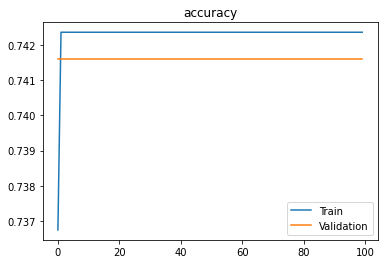

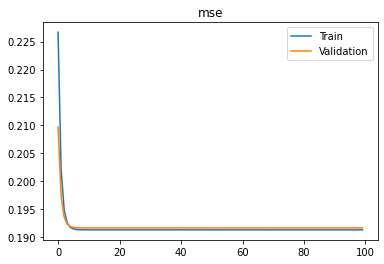

In [9]:
x, shape = make_flat(images)

model = Sequential()
model.add(Dense(10, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')


history = model.fit(x=x, y=labels, 
                    epochs=100, 
                    verbose=1,
                    validation_split=0.25)

display(model.summary())


plot_results(history.history, ['accuracy', 'mse'])

### Define Callbacks

In [5]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25),
             ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]


### Entire train dataset, validation split

##### Create and fit model

In [11]:
x, shape = make_flat(images)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

history = model.fit(x=x, y=labels, 
                    callbacks = callbacks,
                    epochs=500, 
                    validation_split=0.25, 
                    verbose=1)

#best_model = keras.models.load_model('best_model.h5')

Epoch 1/500
123/123 [==============================] - 2s 12ms/step - loss: 1.1843 - accuracy: 0.7015 - mse: 0.2120 - val_loss: 0.3805 - val_accuracy: 0.7416 - val_mse: 0.1286
Epoch 2/500
123/123 [==============================] - 1s 9ms/step - loss: 0.4300 - accuracy: 0.8007 - mse: 0.1425 - val_loss: 0.3579 - val_accuracy: 0.7982 - val_mse: 0.1229
Epoch 3/500
123/123 [==============================] - 1s 9ms/step - loss: 0.3273 - accuracy: 0.8614 - mse: 0.1068 - val_loss: 0.3186 - val_accuracy: 0.8463 - val_mse: 0.1065
Epoch 4/500
123/123 [==============================] - 1s 9ms/step - loss: 0.3077 - accuracy: 0.8840 - mse: 0.1005 - val_loss: 0.2870 - val_accuracy: 0.9220 - val_mse: 0.0881
Epoch 5/500
123/123 [==============================] - 1s 9ms/step - loss: 0.2625 - accuracy: 0.9082 - mse: 0.0839 - val_loss: 0.3023 - val_accuracy: 0.8861 - val_mse: 0.0939
Epoch 6/500
123/123 [==============================] - 1s 10ms/step - loss: 0.2671 - accuracy: 0.9014 - mse: 0.0851 - val_lo

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                1572896   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 1,572,962
Trainable params: 1,572,962
Non-trainable params: 0
_________________________________________________________________


None

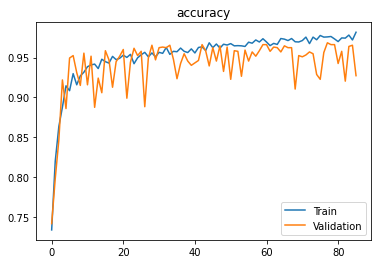

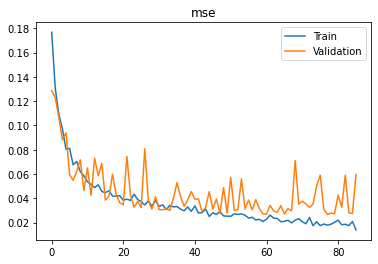

In [12]:
display(model.summary())

plot_results(history.history, ['accuracy', 'mse'])

### Create balanced dataset

### Create model with resampled dataset

### Add Regularization

Epoch 1/500
123/123 [==============================] - 3s 14ms/step - loss: 3.9842 - accuracy: 0.6968 - mse: 0.2182 - val_loss: 3.5290 - val_accuracy: 0.8830 - val_mse: 0.1219
Epoch 2/500
123/123 [==============================] - 1s 11ms/step - loss: 3.5035 - accuracy: 0.8223 - mse: 0.1289 - val_loss: 3.3091 - val_accuracy: 0.8800 - val_mse: 0.0824
Epoch 3/500
123/123 [==============================] - 1s 12ms/step - loss: 3.3250 - accuracy: 0.8728 - mse: 0.0910 - val_loss: 3.3156 - val_accuracy: 0.8394 - val_mse: 0.1121
Epoch 4/500
123/123 [==============================] - 1s 12ms/step - loss: 3.1997 - accuracy: 0.9042 - mse: 0.0736 - val_loss: 3.1998 - val_accuracy: 0.8800 - val_mse: 0.0905
Epoch 5/500
123/123 [==============================] - 1s 12ms/step - loss: 3.1245 - accuracy: 0.9024 - mse: 0.0722 - val_loss: 2.9840 - val_accuracy: 0.9450 - val_mse: 0.0433
Epoch 6/500
123/123 [==============================] - 1s 12ms/step - loss: 3.0741 - accuracy: 0.9030 - mse: 0.0739 - va

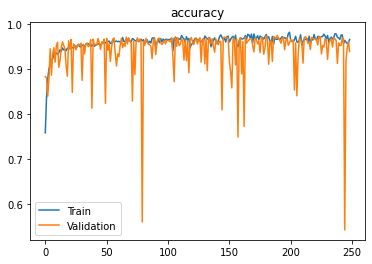

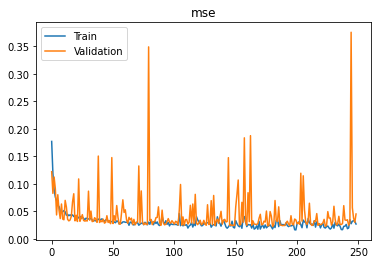

In [13]:
LAMBDA = 0.005
x, shape = make_flat(images)


model = Sequential()
model.add(Dense(256, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x, y=labels, 
                    callbacks=callbacks, 
                    epochs=500, 
                    validation_split=0.25,
                    verbose=1)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Add Dropout

Epoch 1/500
123/123 [==============================] - 3s 16ms/step - loss: 3.8121 - accuracy: 0.7037 - mse: 0.2108 - val_loss: 3.6629 - val_accuracy: 0.7416 - val_mse: 0.1834
Epoch 2/500
123/123 [==============================] - 1s 12ms/step - loss: 3.6465 - accuracy: 0.7371 - mse: 0.1872 - val_loss: 3.4463 - val_accuracy: 0.7424 - val_mse: 0.1295
Epoch 3/500
123/123 [==============================] - 1s 12ms/step - loss: 3.4814 - accuracy: 0.7695 - mse: 0.1530 - val_loss: 3.2662 - val_accuracy: 0.8631 - val_mse: 0.0953
Epoch 4/500
123/123 [==============================] - 1s 12ms/step - loss: 3.3083 - accuracy: 0.8203 - mse: 0.1163 - val_loss: 3.1877 - val_accuracy: 0.8754 - val_mse: 0.0945
Epoch 5/500
123/123 [==============================] - 1s 11ms/step - loss: 3.2191 - accuracy: 0.8437 - mse: 0.1056 - val_loss: 3.0562 - val_accuracy: 0.9113 - val_mse: 0.0703
Epoch 6/500
123/123 [==============================] - 1s 12ms/step - loss: 3.1076 - accuracy: 0.8615 - mse: 0.0940 - va

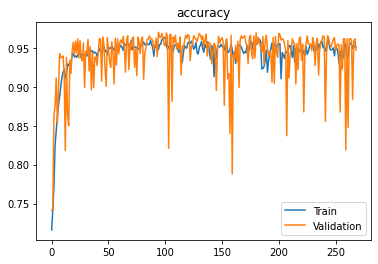

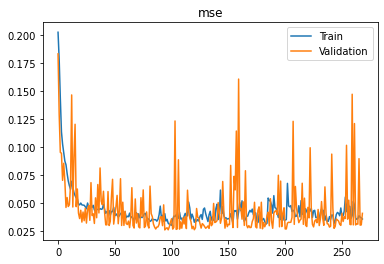

In [14]:
x, shape = make_flat(images)


LAMBDA = 0.005
DROPOUT = 0.3

model = Sequential()
model.add(Dense(256, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x, y=labels, 
                    callbacks=callbacks, 
                    epochs=500,
                    validation_split=0.25)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Remove the layer of 256 notes from previous model

Epoch 1/500
123/123 [==============================] - 2s 13ms/step - loss: 1.7463 - accuracy: 0.6910 - mse: 0.2366 - val_loss: 1.2991 - val_accuracy: 0.7416 - val_mse: 0.1847
Epoch 2/500
123/123 [==============================] - 1s 9ms/step - loss: 1.3059 - accuracy: 0.7317 - mse: 0.1907 - val_loss: 1.1696 - val_accuracy: 0.7416 - val_mse: 0.1449
Epoch 3/500
123/123 [==============================] - 1s 9ms/step - loss: 1.1951 - accuracy: 0.7446 - mse: 0.1564 - val_loss: 1.0619 - val_accuracy: 0.7416 - val_mse: 0.1184
Epoch 4/500
123/123 [==============================] - 1s 10ms/step - loss: 1.1347 - accuracy: 0.7504 - mse: 0.1390 - val_loss: 1.0398 - val_accuracy: 0.8326 - val_mse: 0.1183
Epoch 5/500
123/123 [==============================] - 1s 9ms/step - loss: 1.0527 - accuracy: 0.8341 - mse: 0.1170 - val_loss: 0.9799 - val_accuracy: 0.8616 - val_mse: 0.1015
Epoch 6/500
123/123 [==============================] - 1s 10ms/step - loss: 1.0523 - accuracy: 0.8112 - mse: 0.1237 - val_l

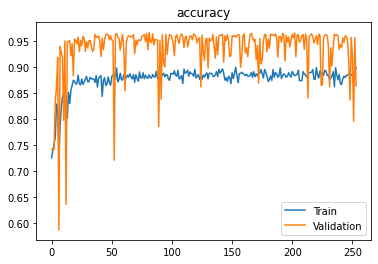

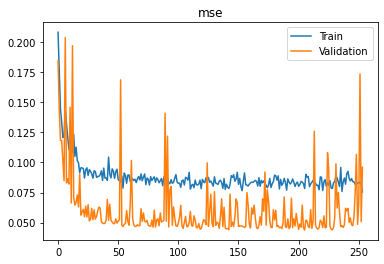

In [15]:
x, shape = make_flat(images)


LAMBDA = 0.005
DROPOUT = 0.3

model = Sequential()

model.add(Dense(64, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x, y=labels, 
                    callbacks=callbacks, 
                    epochs=500,
                    validation_split=0.25)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Use Conv2D() instead of Dense() for first two layers

In [ ]:
LAMBDA = 0.005
DROPOUT = 0.3

model = Sequential()

model.add(Conv2D(64, activation='relu', kernel_size=5, input_shape=images.shape, padding='same'))
model.add(Conv2D(32, activation='relu', kernel_size=5, padding='same'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=images, y=labels, 
                    callbacks=callbacks, 
                    epochs=500,
                    validation_split=0.25)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Run top performing model on Test data

#### Import test data

In [ ]:
path = COLAB_PATH_TEST
BATCH_SIZE = 32
data_tf_test = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                image_size=(128, 128), # Can work up to 256
                                                batch_size=BATCH_SIZE,
                                                class_names=['NORMAL', 'PNEUMONIA'],                                                
                                                seed=RANDOM_STATE)

print('CLASS NAMES:', data_tf_test.class_names, 'CORRESPOND TO [0,1]')

for i, item in enumerate(data_tf_test.as_numpy_iterator()):
    if i == 0:
        images_test = np.array(item[0])
        labels_test = np.array(item[1])
    else:
        images_test = np.concatenate([images_test, item[0]], axis=0)
        labels_test = np.concatenate([labels_test, item[1]], axis=0)
        if i % 10 == 0:
            print(int(i/(5232/BATCH_SIZE)*100), '%')

images_test /= 256

labels_test_inverted = np.array([0 if i == 1 else 1 for i in labels_test])
labels_test = np.concatenate([labels_test_inverted.reshape(-1,1), labels_test.reshape(-1,1)], axis=1)

data_tf_test = None # clear RAM
print('Data shape:', images_test.shape)
print('Label shape:', labels_test.shape)

In [ ]:
best_model.evaluate(images_test, labels_test)